In [1]:
import csv, json, pickle
from pathlib import Path
from collections import defaultdict
from IPython.display import clear_output

from typing import Any, Callable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod

import logging
logging.basicConfig(level=logging.INFO)

import networkx as nx
from rdkit import Chem
from openff.units import unit
from openff.interchange import Interchange

from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule, Atom
from openff.toolkit.utils import toolkit_registry
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.typing.engines.smirnoff import parameters as offtk_parameters

from openmm import LangevinMiddleIntegrator
from openmm.app import Simulation, PDBReporter, StateDataReporter
from openmm.unit import kelvin, picosecond, picoseconds, nanometer # need to do some unit conversion with both packages

INFO:rdkit:Enabling RDKit 2022.03.5 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Useful functions for charge averaging and simulation

In [2]:
# Charge calculation methods
def search_mol_files(filename : str, parent_path : Path=Path.cwd()/'compatible_pdbs', extensions : tuple[str, ...]=('pdb', 'json')) -> dict[str, Path]:
    '''Search file tree for a pdb and monomer file with matching names'''
    mol_files = {
        ext : path
            for path in parent_path.glob('**/*.*')
                for ext in extensions
                    if path.name == f'{filename}.{ext}'
    }

    for ext in extensions:
        if ext not in mol_files:
            raise FileNotFoundError(f'Could not find a(n) {ext} file \"{filename}.{ext}\"')
    else:
        return mol_files

def load_mol_and_topo(pdb_path : Path, json_path : Path, verbose : bool=False):
    '''Load Molecule and Topology from a pdb and a monomer json file, performing residue matching on monomer units
    Assumes that the pdb only contains has ONE simple homopolymer (will only load first molecule if multiple are present'''
    off_topology, _, error = Topology.from_pdb_and_monomer_info(str(pdb_path), json_path, strict=True, verbose=verbose)
    mol = next(off_topology.molecules) # get the first molecule (assumed to be the polymer of interest)

    return mol, off_topology

def poll_and_count_molecules(pdb_folder : Path, outname : str=None, save_fmt : str='json') -> dict[str, int]:
    '''Takes a path to a folder containing multiple .pdb files and produces
    a csv listing all found molecules and how many atoms each contains'''
    mol_sizes = {}
    mol_names = {path.stem for path in pdb_folder.iterdir()}
    for name in mol_names:
        try:
            mol_files = search_mol_files(name)
            mol, topology = load_mol_and_topo(mol_files['pdb'], mol_files['json'])  # will raise exception if files for molecule are not found
            mol_sizes[name] = len(mol.atoms)
        except FileNotFoundError:
            pass

    if outname is not None: # also write to file if a name for the output is specified
        outpath = pdb_folder/f'{outname}.{save_fmt}'
        outpath.touch()

        with outpath.open('w') as mol_file:
            if save_fmt == 'csv':
                writer = csv.writer(mol_file, delimiter=',')
                writer.writerow(['Molecule Name', '# Atoms']) # add columns headers
                for mol_name, mol_size in mol_sizes.items():
                    writer.writerow([mol_name, mol_size])

            elif save_fmt == 'json':
                json.dump(mol_sizes, mol_file, indent=4)
            else:
                raise NotImplementedError(f'No save method for .{save_fmt} output supported')

    return mol_sizes

def generate_molecule_charges(mol : Molecule, toolkit_method : str='openeye', partial_charge_method : str='am1bcc') -> Molecule:
    '''Takes a Molecule object and computes partial charges with AM1BCC using toolkit method of choice. Returns charged molecule'''
    toolkits = {
        'rdkit' : RDKitToolkitWrapper,
        'openeye' : OpenEyeToolkitWrapper,
        'ambertools' : AmberToolsToolkitWrapper
    }

    mol.assign_partial_charges( # finally, assign partial charges using those 10 conformers generated 
        partial_charge_method=partial_charge_method, 
        toolkit_registry=toolkits.get(toolkit_method)()
    )
    charged_mol = mol # rename for clarity
    # get some conformers to run elf10 charge method. By default, `mol.assign_partial_charges`
    # uses 500 conformers, but we can generate and use 10 here for demonstration
    # charged_mol.generate_conformers(
    #     n_conformers=10,
    #     rms_cutoff=0.25 * unit.angstrom,
    #     make_carboxylic_acids_cis=True,
    #     toolkit_registry=RDKitToolkitWrapper()
    # ) # very slow for large polymers! 

    print(f'final molecular charges: {charged_mol.partial_charges}')
    # note: the charged_mol has metadata about which monomers were assigned where as a result of the chemicaly info assignment.
    # This can be a way to break up the molecule into repeating sections to partition the library charges 
    for atom in charged_mol.atoms:
        assert(atom.metadata['already_matched'] == True)
        # print(atom.metadata['residue_name'])
    
    return charged_mol # code for exact how thely above function works can be found in openff/toolkit/utils/openeye_wrapper.py under the assign_partial_charges()

# charge averaging methods
ChargeMap = dict[int, float] # makes typehinting clearer

class ChargeDistributionStrategy(ABC):
    '''Interface for defining how excess charge should be distributed within averaged residues
    to ensure an overall net 0 charge for each monomer fragment'''
    @abstractmethod
    def determine_distribution(self, base_charges : ChargeMap, struct : nx.Graph) -> ChargeMap:
        pass

class UniformDistributionStrategy(ChargeDistributionStrategy):
    '''Simplest possible strategy, distribute any excess charge evenly among all molecules in residue
    Each charge effectively becomes an average of averages when viewed in the context of the whole polymer'''
    def determine_distribution(self, net_charge : float, base_charges: ChargeMap, struct: nx.Graph) -> ChargeMap:
        charge_offset = net_charge / len(base_charges) # net charge divided evenly amongst atoms (average of averages, effectively)
        return {sub_id : charge_offset for sub_id in base_charges}


@dataclass
class Accumulator:
    '''Compact container for accumulating averages'''
    sum : float = 0.0
    count : int = 0

    @property
    def average(self) -> float:
        return self.sum / self.count

@dataclass
class AvgResidueCharges:
    '''Dataclass for more conveniently storing averaged charges for a residue group'''
    charges : ChargeMap
    residue_name : str
    SMARTS : str
    mol_fragment : Chem.rdchem.Mol

    CDS : ChargeDistributionStrategy = field(default_factory=UniformDistributionStrategy) # set default strategy here

    def distrib_mono_charges(self) -> None:
        '''Distribute any excess charge amongst residue to ensure neutral, integral net charge'''
        net_charge = sum(chg for chg in self.charges.values())
        distrib = self.CDS.determine_distribution(net_charge, base_charges=self.charges, struct=self.mol_fragment)
        for sub_id, charge in self.charges.items():
            self.charges[sub_id] = charge - distrib[sub_id] # subtract respective charge offsets from each atom's partial charge


def find_repr_residues(cmol : Molecule) -> dict[str, int]:
    '''Determine names and smallest residue numbers of all unique residues in charged molecule
    Used as representatives for generating labelled SMARTS strings '''
    rep_res_nums = defaultdict(set) # numbers of representative groups for each unique residue, used to build SMARTS strings
    for atom in cmol.atoms: 
        rep_res_nums[atom.metadata['residue_name']].add(atom.metadata['residue_number']) # collect unique residue numbers

    for res_name, ids in rep_res_nums.items():
        rep_res_nums[res_name] = min(ids) # choose group with smallest id of each residue to denote representative group

    return rep_res_nums

def get_averaged_charges_orig(cmol : Molecule, monomer_data : dict[str, dict], distrib_mono_charges : bool=False) -> list[AvgResidueCharges]:
    '''Takes a charged molecule and a dict of monomer structure data and averages charges for each repeating residue. 
    Returns a list of AvgResidueCharge objects each of which holds:
        - A dict of the averaged charges by atom 
        - The name of the residue associated with the charges
        - A SMARTS string of the residue's structure'''
    rdmol = cmol.to_rdkit() # create rdkit representation of Molecule to allow for SMARTS generation
    rep_res_nums = find_repr_residues(cmol) # determine ids of representatives of each unique residue

    atom_ids_for_SMARTS = defaultdict(list)
    res_charge_accums   = defaultdict(lambda : defaultdict(Accumulator))
    for atom in cmol.atoms: # accumulate counts and charge values across matching substructures
        res_name, res_num     = atom.metadata['residue_name']   , atom.metadata['residue_number']
        substruct_id, atom_id = atom.metadata['substructure_id'], atom.metadata['pdb_atom_id']

        if res_num == rep_res_nums[res_name]: # if atom is member of representative group for any residue...
            atom_ids_for_SMARTS[res_name].append(atom_id)             # ...collect pdb id...
            rdmol.GetAtomWithIdx(atom_id).SetAtomMapNum(substruct_id) # ...and set atom number for labelling in SMARTS string

        curr_accum = res_charge_accums[res_name][substruct_id] # accumulate charge info for averaging
        curr_accum.sum += atom.partial_charge.magnitude # eschew units (easier to handle, added back when writing to XML)
        curr_accum.count += 1

    avg_charges_by_residue = []
    for res_name, charge_map in res_charge_accums.items():
        # SMARTS = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=atom_ids_for_SMARTS[res_name]) # determine SMARTS for the current residue's representative group
        SMARTS = monomer_data['monomers'][res_name] # extract SMARTS string from monomer data
        charge_map = {substruct_id : accum.average for substruct_id, accum in charge_map.items()} 

        if distrib_mono_charges: # distribute any excess average charge among monomer atoms to ensure no net charge per monomer
            chg_offset = sum(avg for avg in charge_map.values()) / len(charge_map)
            charge_map = {sub_id : avg - chg_offset for sub_id, avg in charge_map.items()}
        
        avg_charges_by_residue.append(AvgResidueCharges(charges=charge_map, residue_name=res_name, SMARTS=SMARTS))

    return avg_charges_by_residue

def get_averaged_charges(cmol : Molecule, monomer_data : dict[str, dict], distrib_mono_charges : bool=True) -> list[AvgResidueCharges]:
    '''Takes a charged molecule and a dict of monomer SMIRKS strings and averages charges for each repeating residue. 
    Returns a list of AvgResidueCharge objects, each of which holds:
        - A dict of the averaged charges by atom 
        - The name of the residue associated with the charges
        - A SMARTS string of the residue's structure
        - An nx.Graph representing the structure of the residue'''
    # rdmol = cmol.to_rdkit() # create rdkit representation of Molecule to allow for SMARTS generation
    mol_graph = cmol.to_networkx()
    rep_res_nums = find_repr_residues(cmol) # determine ids of representatives of each unique residue

    atom_id_mapping   = defaultdict(lambda : defaultdict(int))
    res_charge_accums = defaultdict(lambda : defaultdict(Accumulator))
    for atom in cmol.atoms: # accumulate counts and charge values across matching substructures
        res_name, res_num     = atom.metadata['residue_name']   , atom.metadata['residue_number']
        substruct_id, atom_id = atom.metadata['substructure_id'], atom.metadata['pdb_atom_id']

        if res_num == rep_res_nums[res_name]: # if atom is member of representative group for any residue...
            # rdmol.GetAtomWithIdx(atom_id).SetAtomMapNum(atom_id)  # ...and set atom number for labelling in SMARTS string
            atom_id_mapping[res_name][atom_id] = (substruct_id, atom.symbol) # ...collect pdb id...

        curr_accum = res_charge_accums[res_name][substruct_id] # accumulate charge info for averaging
        curr_accum.sum += atom.partial_charge.magnitude # eschew units (easier to handle, added back when writing to XML)
        curr_accum.count += 1

    avg_charges_by_residue = []
    for res_name, charge_map in res_charge_accums.items():
        # rdSMARTS = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=atom_id_mapping[res_name].keys()) # determine SMARTS for the current residue's representative group
        # mol_frag = Chem.rdmolfiles.MolFromSmarts(rdSMARTS) # create fragment from rdkit SMARTS to avoid wild atoms (using rdkit over nx.subgraph for more detailed atomwise info)
        
        SMARTS = monomer_data['monomers'][res_name] # extract SMARTS string from monomer data
        charge_map = {substruct_id : accum.average for substruct_id, accum in charge_map.items()} 
        atom_id_map = atom_id_mapping[res_name]

        mol_frag = mol_graph.subgraph(atom_id_map.keys()) # isolate subgraph of residue to obtain connectivity info for charge redistribution
        for atom_id, (substruct_id, symbol) in atom_id_map.items(): # assign additional useful info not present by default in graph
            mol_frag.nodes[atom_id]['substruct_id'] = substruct_id
            mol_frag.nodes[atom_id]['symbol'] = symbol

        chgd_res = AvgResidueCharges(
            charges=charge_map,
            residue_name=res_name,
            SMARTS=SMARTS,
            mol_fragment=mol_frag
        )
        if distrib_mono_charges: # only distribute charges if explicitly called for (enabled by default)
            chgd_res.distrib_mono_charges()
        avg_charges_by_residue.append(chgd_res)

    return avg_charges_by_residue, atom_id_mapping

def write_new_library_charges(avgs : list[AvgResidueCharges], offxml_src : Path, output_path : Path) -> tuple[ForceField, list[offtk_parameters.LibraryChargeHandler]]:
    '''Takes dict of residue-averaged charges to generate and append library charges to an .offxml file of choice, creating a new xml with the specified filename'''
    assert(output_path.suffix == '.offxml') # ensure output path is pointing to correct file type
    forcefield = ForceField(offxml_src)     # simpler to add library charges through forcefield API than to directly write to xml
    lc_handler = forcefield["LibraryCharges"]

    lib_chgs = [] #  all library charges generated from the averaged charges for each residue
    for averaged_res in avgs:
        lc_entry = { # stringify charges into form usable for library charges
            f'charge{cid}' : f'{charge} * elementary_charge' # +1 accounts for 1-index to 0-index when going from smirks atom ids to substructure ids
                for cid, charge in averaged_res.charges.items()
        } 

        lc_entry['smirks'] = averaged_res.SMARTS # add SMIRKS string to library charge entry to allow for correct labelling
        lc_params = offtk_parameters.LibraryChargeHandler.LibraryChargeType(allow_cosmetic_attributes=True, **lc_entry) # must enable cosmetic params for general kwarg passing
        
        lc_handler.add_parameter(parameter=lc_params)
        lib_chgs.append(lc_params)  # record library charges for reference
    forcefield.to_file(output_path) # write modified library charges to new xml (avoid overwrites in case of mistakes)
    
    return forcefield, lib_chgs

# OpenMM simulation methods
def create_sim_from_interchange(interchange : Interchange) -> Simulation:
    '''Sets up a Simulation object using topology and force field data as specified by an Interchange object
    Converts topologies and positions to OpenMM format from OpenFF formats (can support GROMACS format too in future)'''
    openmm_sys = interchange.to_openmm(combine_nonbonded_forces=True) 
    openmm_top = interchange.topology.to_openmm()
    openmm_pos = interchange.positions.m_as(unit.nanometer) * nanometer
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.0005*picoseconds)

    simulation = Simulation(openmm_top, openmm_sys, integrator)
    simulation.context.setPositions(openmm_pos)

    return simulation

def run_simulation(simulation : Simulation, output_folder : Path, output_name : str='md_sim', num_steps=1000, record_freq=10) -> None:
    '''Takes a Simulation object, performs energy minimization, and runs simulation for specified number of time steps
    Recording PBD frames and numerical data to file at the specified frequency'''
    folder_name = str(output_folder) # for some reason OpenMM simulations don;t like Path objects (only take strings)

    # for saving pdb frames and reporting state/energy data
    pdb_rep = PDBReporter(f'{folder_name}/{output_name}_frames.pdb', record_freq)  # save frames at the specified interval
    state_rep = StateDataReporter(f'{folder_name}/{output_name}_data.csv', record_freq, step=True, potentialEnergy=True, temperature=True)
    reporters = (pdb_rep, state_rep)

    # minimize and run simulation
    simulation.minimizeEnergy()
    simulation.saveCheckpoint(f'{folder_name}/{output_name}_checkpoint.chk') # save initial minimal state to simplify reloading process
    for rep in reporters:
        simulation.reporters.append(rep) # add any desired reporters to simulaiton for tracking
    simulation.step(num_steps)

## Running averaging code for test molecule

In [3]:
# Get all molecules which will be charge averaged and simulated
pdb_folder = Path.cwd()/'compatible_pdbs'/'simple_polymers'
counts_path = pdb_folder/'Available Polymers.json'

if counts_path.exists(): # if molecules have already been polled, load names/sizes from file...
    with counts_path.open('r') as counts_file:
        mol_sizes = json.load(counts_file)
else:
    mol_sizes = poll_and_count_molecules(pdb_folder=pdb_folder, outname=counts_path.stem, save_fmt='json') # otherwise, repoll and save to file

hard_polymers = ['vulcanizedrubber', 'polyphenylenesulfone'] # pathological or otherwise difficult-to-run polymers that I've encountered
mols_to_use = [mol_name
    for mol_name, mol_size in mol_sizes.items()
        if mol_size < 150 # only keep polymers which are small enough for AM1BCC...
            and mol_name not in hard_polymers # ... and not manually excluded
]

print(mols_to_use)

['naturalrubber', 'PEO_PLGA', 'polyvinylchloride', 'polymethylketone', 'polyethylmethacrylate', 'polyphenyleneII']


In [ ]:
# Perform charge averaging on all target molecules which don't already have averaged LCs; 
# Load forcefield for those which already do 
sample_mols = ['PEO_PLGA']
run_sims = True
prevent_overwrites = False
distrib_mono_charges = True

offxml_src = Path('xml examples/base_library_charges.offxml')
polymer_folder = Path('compatible_pdbs/simple_polymers')
pickle_folder = Path('pickled_molecules')

def get_cmol(mol : Molecule, pickle_path : Path) -> Molecule:
    '''More efficient method for repeatedly obtaining a charged Molecule
    If no molecule file is found, perform AM1BCC and save to file, otherwise load from file'''
    if not pickle_path.exists():
        logging.info('No extant pickled charged Molecule found, performing charging...')
        cmol = generate_molecule_charges(mol, toolkit_method='openeye', partial_charge_method='am1bcc') # perform AM1BCC
        with pickle_path.open('wb') as pickle_file: # write charged molecule to pickle to avoid constantly redoing AM1
            pickle.dump(cmol, pickle_file)
    else:
        logging.info('Unpickling charged Molecule...')
        with pickle_path.open('rb') as pickle_file: # read cmol from file if already extant
            cmol = pickle.load(pickle_file)
    return cmol

for mol_name in mols_to_use: #sample_mols: #
    # DEFINING PATHS, CREATING FOLDERS, AND FETCHING FILES
    logging.info(f'Current molecule: {mol_name}')
    pdb_path = Path(f'compatible_pdbs/simple_polymers/{mol_name}.pdb')
    charged_json = Path(f'charged_jsons/{mol_name}_with_charges.json')
    default_json = polymer_folder/f'{mol_name}.json'
    if charged_json.exists():
        logging.info('Found monomer JSON with precalculated charge data, using...')
        json_path = charged_json
    else:
        logging.info('Using default monomer JSON...')
        json_path = default_json

    with json_path.open('r') as json_file:
        mono_data = json.load(json_file)
    
    output_folder = Path(f'averaged_polymers/{mol_name}')
    output_folder.mkdir(exist_ok=True)
    lc_path = output_folder/f'new {mol_name} charges.offxml' # path to output library charges to
    pickle_path = pickle_folder/f'{mol_name}.pkl'

    # LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
    logging.info(f'Loading and matching molecule "{mol_name}"...')
    mol, topology = load_mol_and_topo(pdb_path, json_path)  # will raise exception if files for molecule are not found
    
    if prevent_overwrites and lc_path.exists(): # check if library charges have already been generated for this molecule
        logging.info('Obtaining partial charges from Library Charge xml...')
        forcefield = ForceField(lc_path, allow_cosmetic_attributes=True)
    else:
        cmol = get_cmol(mol, pickle_path=pickle_path)
        #clear_output() # for Jupyter notebooks only, can freely comment this out
        logging.info(f'Averaging charges over {mol_name} residues...')
        avgs, atom_id_mapping = get_averaged_charges(cmol, monomer_data=mono_data, distrib_mono_charges=distrib_mono_charges) # average charges over unique residues - placed after clear so we can see what averages are computed
        for averaged_res in avgs:
            print(averaged_res, '\n')

        # logging.warning('Library Charge file not found OR overwrite allowed, writing new Library Charge xml...')
        # forcefield, lib_chgs = write_new_library_charges(avgs, offxml_src, output_path=lc_path)
        
        # CREATE JSON WITH AVERAGED CHARGES IF ONE DOES NOT ALREADY EXIST
        if not charged_json.exists():
            logging.info('Writing new monomer JSON with charge data...')
            with default_json.open('r') as old_json:
                json_dat = json.load(old_json)

            charge_entry = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgs}
            json_dat['charges'] = charge_entry

            charged_json.touch()
            with charged_json.open('w') as new_json:
                json.dump(json_dat, new_json, indent=4)

# RUN OpenMM SIMULATION FOR TARGET MOLECULE
    if run_sims:
        logging.info('Running OpenMM sim...')
        forcefield = ForceField(lc_path, allow_cosmetic_attributes=True)
        interchange = Interchange.from_smirnoff(force_field=forcefield, topology=topology, charge_from_molecules=[cmol]) # generate Interchange with new library charges prior to writing to file
        sim = create_sim_from_interchange(interchange)
        run_simulation(sim, output_folder=output_folder, output_name=mol_name, num_steps=10000, record_freq=10)
    logging.info('\n')

## Testing Code for fragment assignmentt and charge distribution strategies

In [5]:
mol_name = 'PEO_PLGA'#'polyethylmethacrylate'

pdb_path = Path(f'compatible_pdbs/simple_polymers/{mol_name}.pdb')
charged_json = Path(f'charged_jsons/{mol_name}_with_charges.json')
default_json = polymer_folder/f'{mol_name}.json'
if charged_json.exists():
    json_path = charged_json
else:
    json_path = default_json

with json_path.open('r') as json_file:
    mono_data = json.load(json_file)

pickle_path = pickle_folder/f'{mol_name}.pkl'
mol, topology = load_mol_and_topo(pdb_path, json_path)  # will raise exception if files for molecule are not found
cmol = get_cmol(mol, pickle_path=pickle_path)

INFO:root:Unpickling charged Molecule...


In [7]:
avgs, atom_id_mapping = get_averaged_charges(cmol, mono_data, distrib_mono_charges=False)

print(avgs[0].charges) # show charged before and after distribution
avgs[0].distrib_mono_charges()
print(avgs[0].charges)

{1: -0.5940300232808416, 2: 0.13015000456168005, 3: 0.12320999735190223, 4: 0.40027999811961007, 5: 0.03387999841167281, 6: 0.03387999841167281, 7: 0.03731999852849791, 8: 0.03731999852849791}
{1: -0.6192812696099281, 2: 0.10489875823259354, 3: 0.09795875102281572, 4: 0.37502875179052353, 5: 0.008628752082586295, 6: 0.008628752082586295, 7: 0.0120687521994114, 8: 0.0120687521994114}


In [ ]:
for i in avgs[0].mol_fragment.nodes:
    print(i, avgs[0].mol_fragment.nodes[i])

/home/tbernat/miniconda3/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tbernat/miniconda3/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


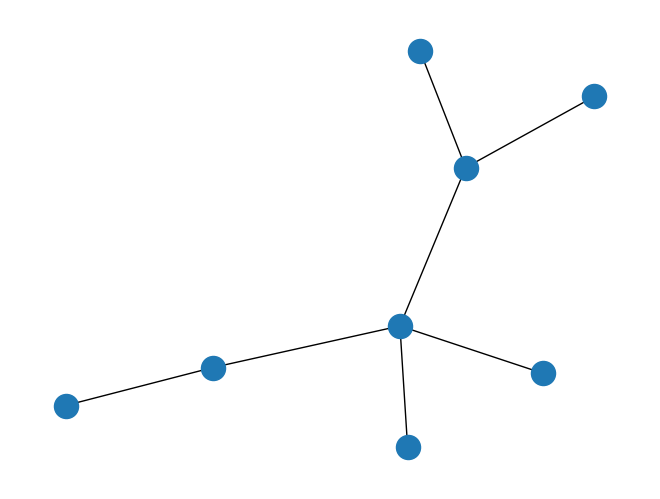

In [8]:
nx.draw(avgs[0].mol_fragment)

## Testing pickling of molecules to avoid constantly rerunning AM1

In [ ]:
mol_name = 'naturalrubber'

polymer_folder = Path('compatible_pdbs/simple_polymers')
pickle_folder = Path('pickled_molecules')

pdb_path = Path(f'compatible_pdbs/simple_polymers/{mol_name}.pdb')
charged_json = Path(f'charged_jsons/{mol_name}_with_charges.json')
default_json = polymer_folder/f'{mol_name}.json'
json_path = charged_json if charged_json.exists() else default_json

def get_cmol(mol : Molecule, pickle_path : Path):
    '''More efficient method for repeatedly obtaining a charged Molecule
    If no molecule file is found, perform AM1BCC and save to file, otherwise load from file'''
    if not pickle_path.exists():
        cmol = generate_molecule_charges(mol, toolkit_method='openeye', partial_charge_method='am1bcc') # perform AM1BCC
        with pickle_path.open('wb') as pickle_file: # write charged molecule to pickle to avoid constantly redoing AM1
            pickle.dump(cmol, pickle_file)
    else:
        with pickle_path.open('rb') as pickle_file: # read cmol from file if already extant
            cmol = pickle.load(pickle_file)
    return cmol

cmol = get_cmol(mol, pickle_path)

## Testing to determine if correct substructure ids are being applied

In [ ]:
rdmol = cmol.to_rdkit() # create rdkit representation of Molecule to allow for SMARTS generation
targ_res_num = 3

atom_ids_for_SMARTS = []
for atom in cmol.atoms: # accumulate counts and charge values across matching substructures
    res_name, res_num     = atom.metadata['residue_name']   , atom.metadata['residue_number']
    substruct_id, atom_id = atom.metadata['substructure_id'], atom.metadata['pdb_atom_id']

    if res_num == targ_res_num: # if atom is member of representative group for any residue...
        atom_ids_for_SMARTS.append(atom_id)             # ...collect pdb id...
        rdmol.GetAtomWithIdx(atom_id).SetAtomMapNum(substruct_id) # ...and set atom number for labelling in SMARTS string

SMARTS = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=atom_ids_for_SMARTS) # determine SMARTS for the current residue's representative group
print(SMARTS)

In [ ]:
for res in avgs:
    print(res.residue_name, sum(chg for chg in res.charges.values()))

In [ ]:
mol_name = 'polyphenyleneII'

polymer_folder = Path('compatible_pdbs/simple_polymers')
output_folder = Path(f'averaged_polymers/{mol_name}')

pdb_path = Path(f'compatible_pdbs/simple_polymers/{mol_name}.pdb')
default_json = polymer_folder/f'{mol_name}.json'
charged_json = Path(f'charged_jsons/{mol_name}_with_charges.json')
json_path = charged_json if charged_json.exists() else default_json

lc_path = output_folder/f'new {mol_name} charges.offxml' # path to output library charges to

# LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
mol, topology = load_mol_and_topo(pdb_path, json_path)  # will raise exception if files for molecule are not found


In [ ]:
lc_path = output_folder/f'new {mol_name} charges.offxml' # path to output library charges to

forcefield = ForceField(lc_path, allow_cosmetic_attributes=True)
interchange = Interchange.from_smirnoff(force_field=forcefield, topology=topology, allow_nonintegral_charges=False) # generate Interchange with new library charges prior to writing to file
sim = create_sim_from_interchange(interchange)
run_simulation(sim, output_folder=Path(f'averaged_polymers/all_sims'), output_name=mol_name, num_steps=1000, record_freq=10)

## Testing to determine which atoms are not being covered by Smirnoff load from LCs

In [ ]:
PVC_matches = {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61}
PEO_matches = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95}

In [ ]:
for atom in mol.atoms:
    if atom.metadata['pdb_atom_id'] not in PEO_matches:
        print(atom.metadata)

In [ ]:
import re

with default_json.open('r') as mono_file:
    jdat = json.load(mono_file)

sub_ids = defaultdict(set)
for atom in mol.atoms:
    sub_ids[atom.metadata['residue_name']].add(atom.metadata['substructure_id'])

for res_name, smirks in jdat['monomers'].items():
    ids = {int(i) for i in re.findall('\:(\d+)', smirks)}
    print(smirks, sub_ids[res_name], ids)

## Permutation Experiment

In [ ]:
# Create every permutation of library charges to test which orderings produce full atomic coverage (i.e. don't need charge recalculation) 
from itertools import permutations

mol_name = 'naturalrubber'
offxml_src = Path('xml examples/openff_unconstrained_with_library_charges-2.0.0.offxml')
perm_output_folder = Path(f'averaged_polymers/{mol_name} perms')
perm_output_folder.mkdir(exist_ok=True)

mol, topology, mol_files = fetch_mol(mol_name)  # will raise exception if files for molecule are not found
cmol = generate_molecule_charges(mol, toolkit_method='openeye', partial_charge_method='am1bcc') # perform AM1BCC
#clear_output() # for Jupyter notebooks only, can freely comment this out
avgs = get_averaged_charges(cmol) # average charges over unique residues - placed after clear so we can see what averages are computed
for averaged_res in avgs:
    print(averaged_res, '\n')

for perm in permutations(avgs):
    name = '-'.join(avg_res.residue_name for avg_res in perm)
    perm_outpath = perm_output_folder/f'{name}.offxml'
    forcefield, lib_chgs = write_new_library_charges(avgs, offxml_src, output_path=perm_outpath)

for xml_path in perm_output_folder.iterdir():
    print(xml_path.stem)
    forcefield = ForceField(xml_path, allow_cosmetic_attributes=True)
    interchange = Interchange.from_smirnoff(force_field=forcefield, topology=topology, charge_from_molecules=[cmol]) # generate Interchange with new library charges prior to writing to file
    sim = create_sim_from_interchange(interchange)
    run_simulation(sim, output_folder=perm_output_folder, output_name=name, num_steps=100, record_freq=10)

## Example for assigning atom ids in SMARTS

In [ ]:
rdmol = cmol.to_rdkit()
smarts_no_map = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=[i for i in range(5,10)])
# how to specify atom map numbers
i = 0
for atom in rdmol.GetAtoms():
    i += 1
    atom.SetAtomMapNum(atom.GetIdx())
smarts_yes_map = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=[i for i in range(5,10)])

print(smarts_no_map)
print(smarts_yes_map)

In [ ]:
for atom in rdmol.GetAtoms(): # checking that atom types match between rdkit and openff version
    n = atom.GetIdx()
    if atom.GetAtomicNum() != cmol.atoms[n].metadata['atomic_number']:
        print(f'Mismatch at atom {n}')
        break
else:
    print('All good!')


## Playing with NX to get a feel for it

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_node(0, val=6, attr='stuff')
G.add_node(3, val=7, attr='other')
G.nodes[3]['attr']

In [ ]:
G.add_edge(1, 2, weight=10)
G.edges[1, 2]['weight']

## Testing XML encoding

In [ ]:
import xml
import xml.etree.ElementTree as ET

p = Path('xml examples/test.offxml')
p.touch()

top = ET.Element('a')
new = ET.SubElement(top, 'b')
new.attrib = {'first' : '4', 'second' : '5'}
 
tree = ET.ElementTree(top)

ET.dump(top) # print out tree
tree.write(p, encoding='utf-8', xml_declaration=True) # write to file